# NATRE variance budget

Reproducing the Ferrari & Polzin (2005) estimate using NATRE data, and comparing differences with our version

In [1]:
%load_ext watermark
%matplotlib inline

import glob

import cf_xarray as cfxr
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import xarray as xr
from IPython.display import Image

import eddydiff as ed

xr.set_options(keep_attrs=True)

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 200
plt.style.use("ggplot")

%watermark -iv

cf_xarray  : 0.4.1.dev21+gab9dc66
dcpy       : 0.1
xarray     : 0.17.1.dev3+g48378c4b1
matplotlib : 3.4.1
numpy      : 1.20.2
eddydiff   : 0.1
distributed: 2021.6.2



In [2]:
if "client" in locals():
    client.cluster.close()
    client.close()
client = distributed.Client(n_workers=2, threads_per_worker=2)
client

<Client: 'tcp://127.0.0.1:35443' processes=2 threads=4, memory=31.10 GiB>

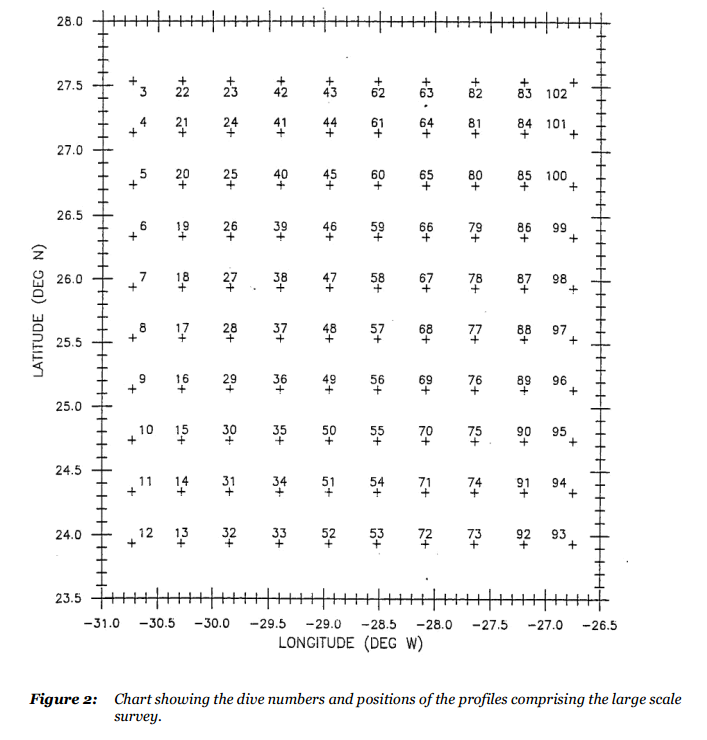

In [3]:
Image("../images/natre-large-scale.png")

## Read dataset

created using ``eddydiff.natre.combine_natre_files()``



In [759]:
natre = ed.natre.read_natre().load()

/home/deepak/work/python/xarray/xarray/core/computation.py:742: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/home/deepak/work/python/xarray/xarray/core/computation.py:742: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


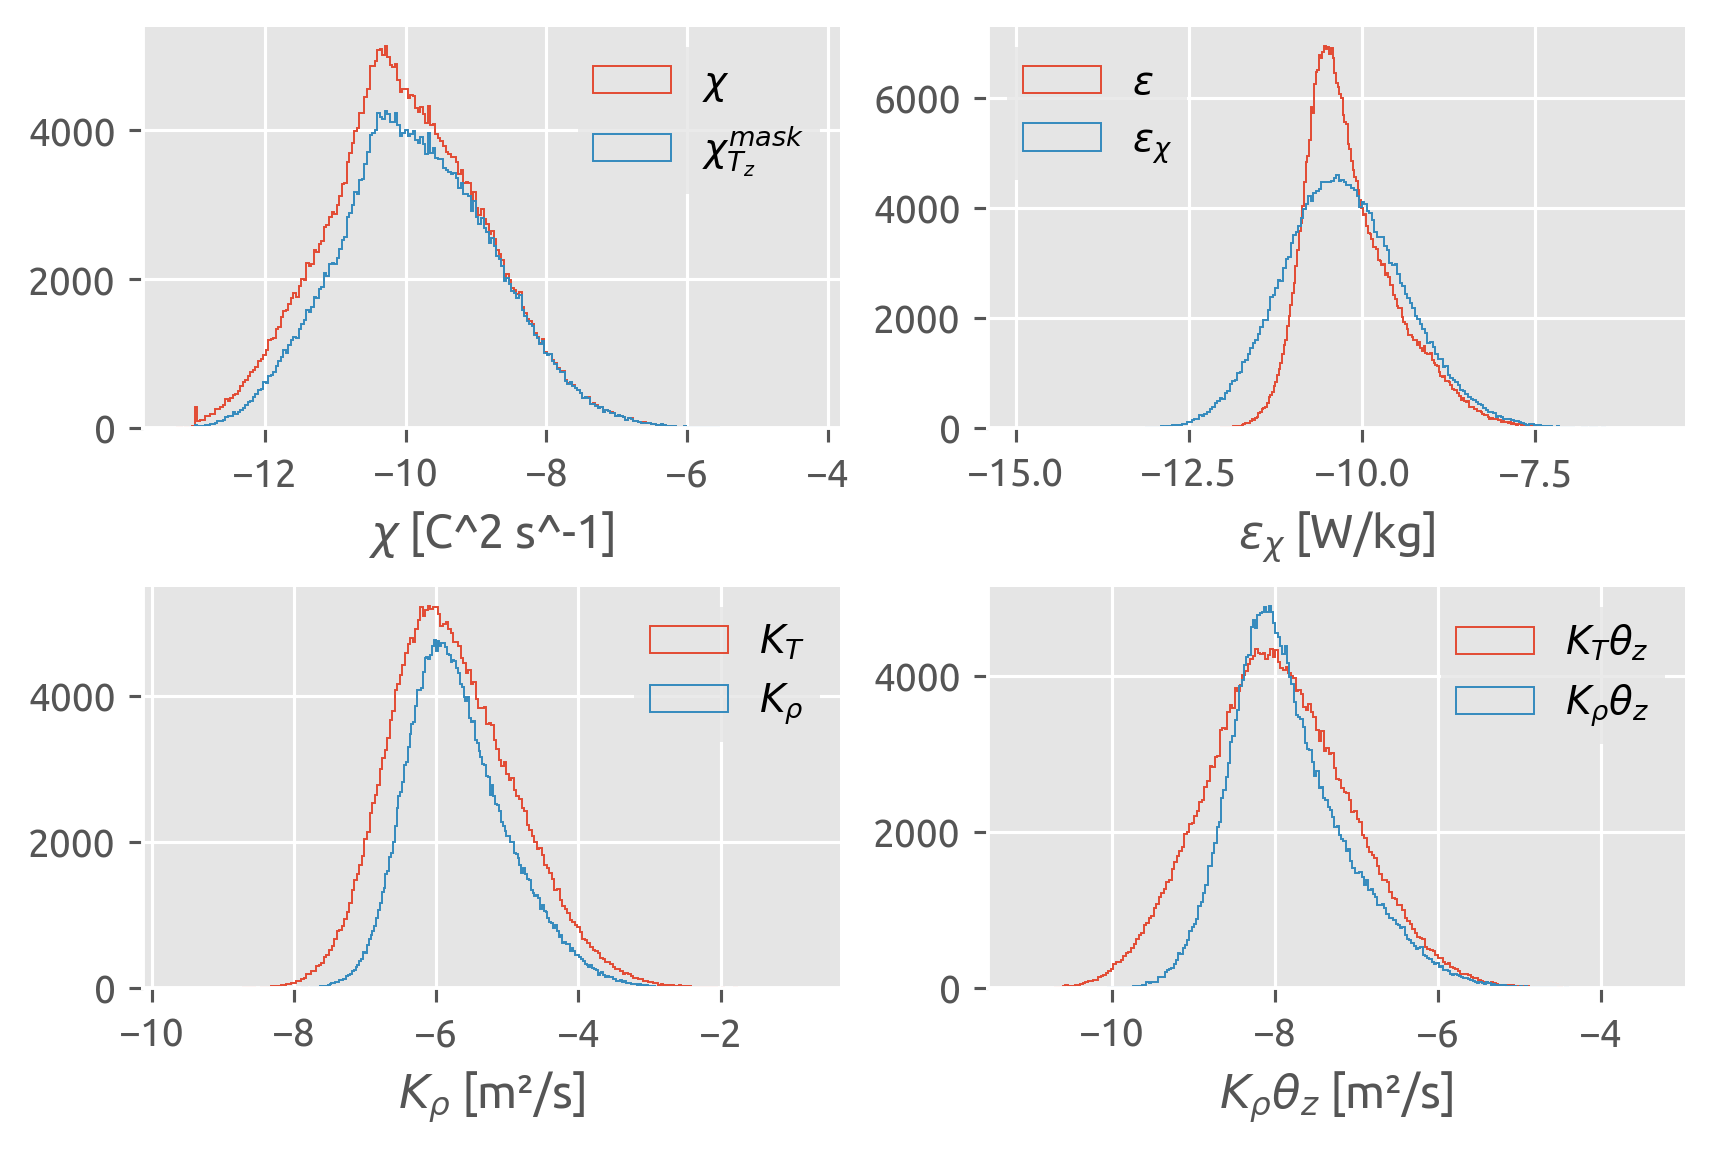

In [6]:
ed.plot.histogram_turb_estimates(natre)

## TS plot

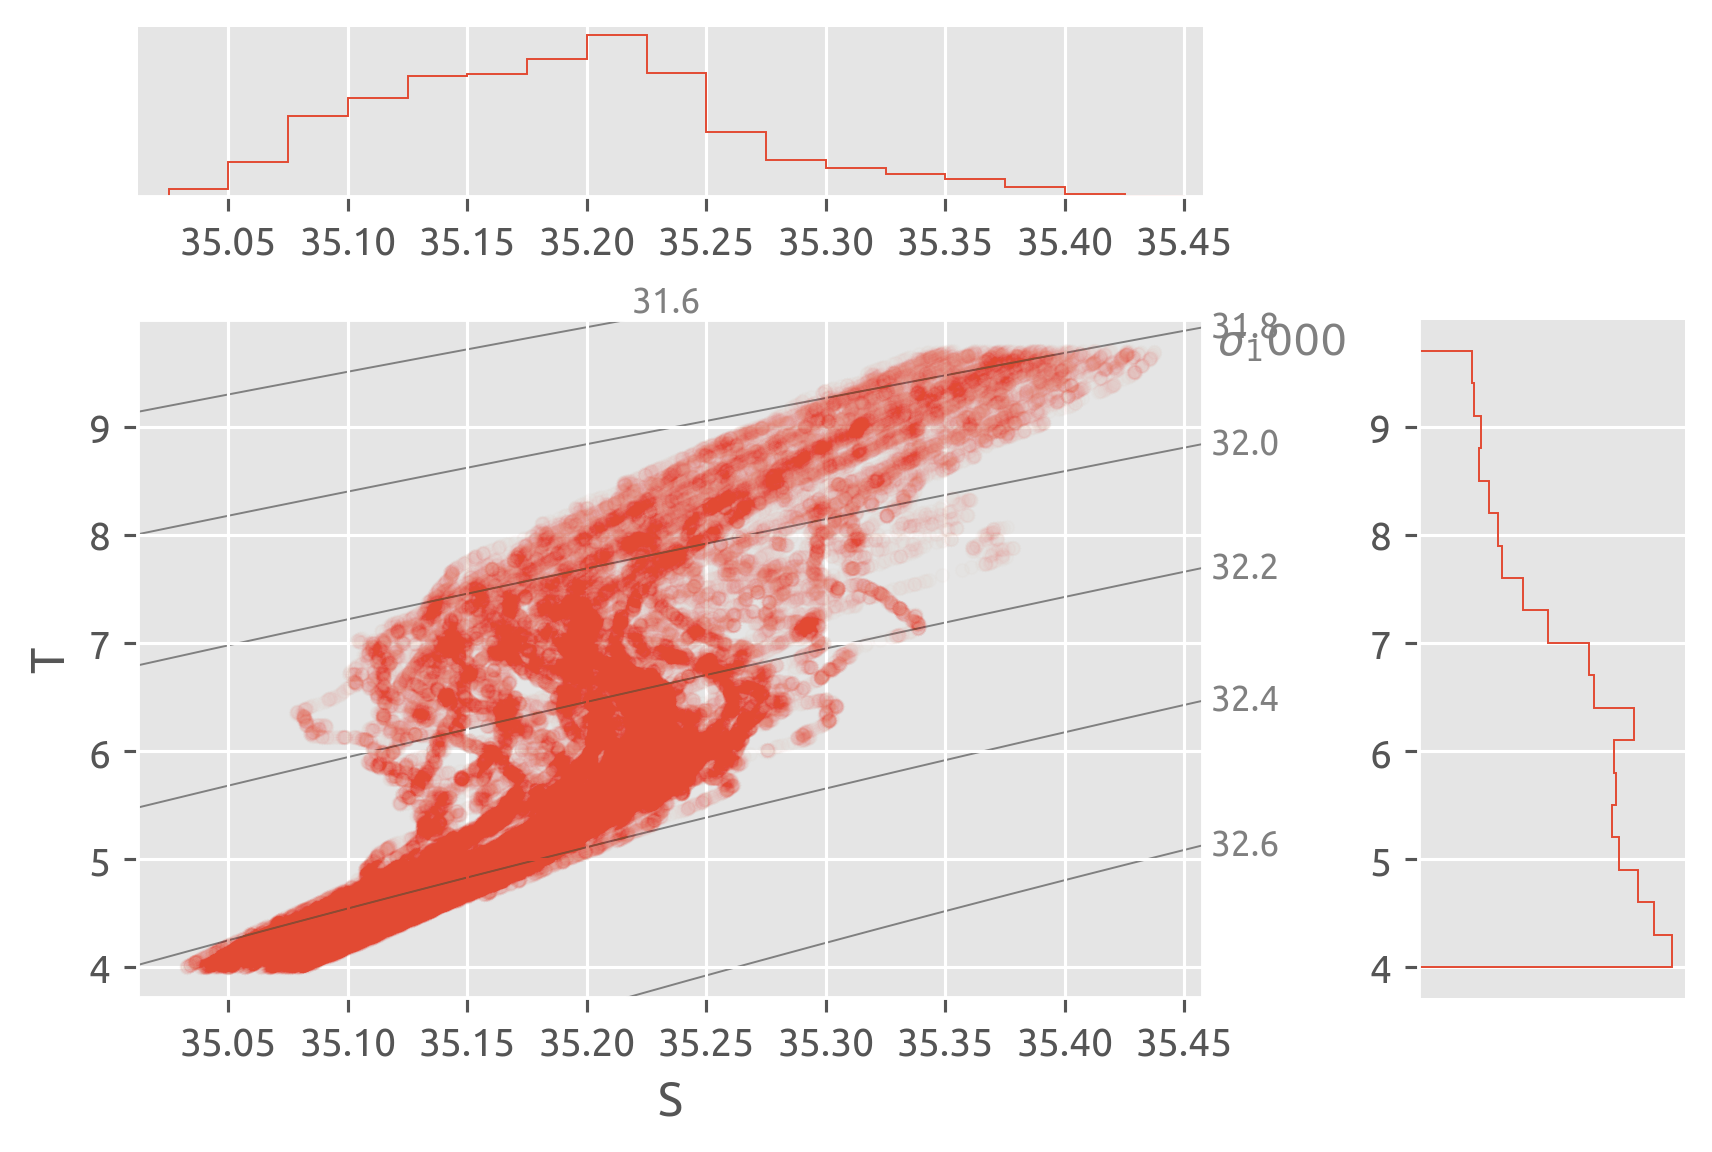

In [7]:
hdl, axes = dcpy.oceans.TSplot(
    natre.salt[::2],
    natre.theta[::2],
    Pref=1000,
    # rho_levels=bins,
    Sbins=np.arange(35, 35.5, 0.025),
    Tbins=np.arange(4, 10, 0.3),
    hexbin=False,
    plot_kwargs={"alpha": 0.01},
)

In [8]:
(
    natre["chi"].rolling(depth=100, center=True, min_periods=1).mean().compute()
).plot.line(
    y="depth",
    col="longitude",
    row="latitude",
    yincrease=False,
    xlim=[1e-12, 1e-7],
    ylim=(2000, 0),
    xscale="log",
)

## Procedure

The large-scale average operator ⟨⟩ represents 
1. a horizontal average over the survey lateral scale,
2. a vertical average over O(100) m, and
3. a time average over the 18-day survey.


The mean fields are derived by averaging all variables along neutral-density surfaces $γ_n$

Mean vertical gradients $∂_z θ_m$, $∂_z S_m$, and $∂_z b_m$, are calculated from O(100)-m linear fits to $θ_m(z_n)$,
$S_m(z_n)$, and $b_m(z_n)$, where $z_n$ is the mean depth of each surface $γ_n$. 

large-scale temperature gradient $|∇_n θ_m|$ is estimated by fitting
a plane to the 100 stations in the 400 km × 400 km
large-scale survey grid and rms is computed as the standard deviation of the departures from the plane fit. 

In theory, these bins are approx. 100m apart in neutral density

### Choose bins

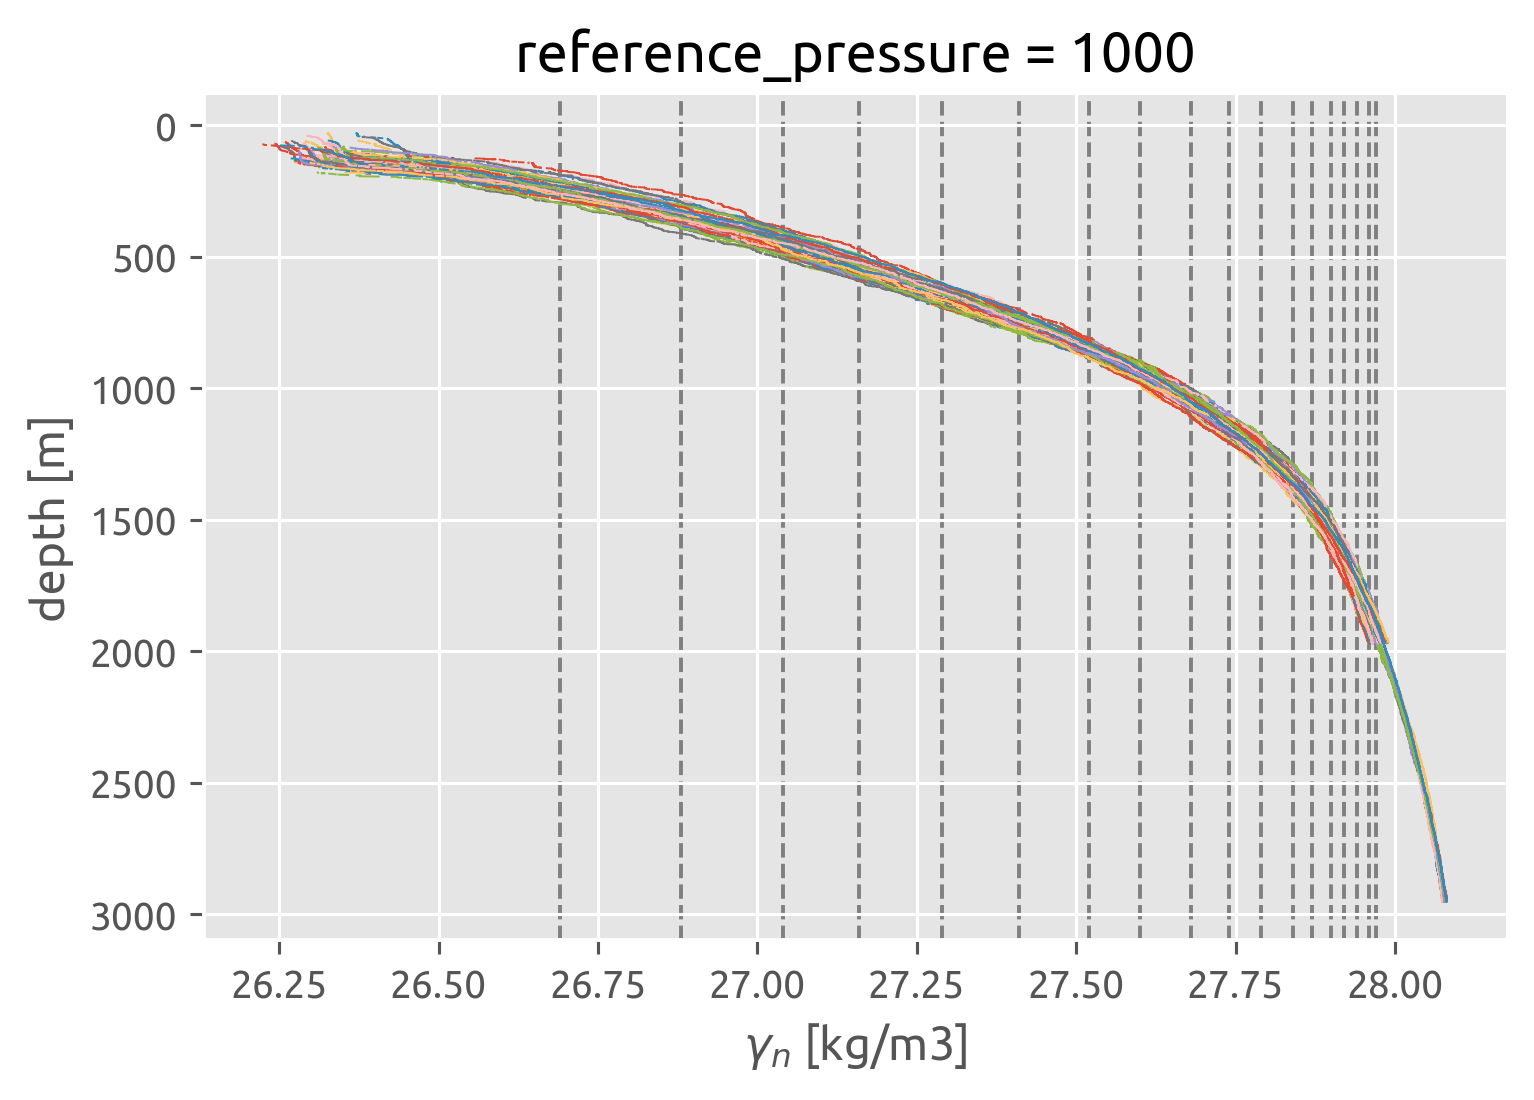

In [14]:
# bins = (
#    natre.gamma_n.mean(["latitude", "longitude"])
#    .interp(depth=np.arange(150, 2001, 100))
#    .dropna("depth")
#    .data
# )

bins = ed.sections.choose_bins(natre.gamma_n, depth_range=np.arange(150, 2001, 100))
natre.gamma_n.stack({"latlon": ["latitude", "longitude"]}).drop("latlon").cf.plot(
    hue="latlon",
    y="depth",
    lw=0.5,
    add_legend=False,
    yincrease=False,
)
dcpy.plots.linex(bins)

## Make estimate

 
**Vertical gradients:** `ed.sections.fit1D`

> Mean vertical gradients $∂_z θ_m$, $∂_z S_m$, and $∂_z b_m$, are calculated from O(100)-m linear fits to $θ_m(z_n)$, $S_m(z_n)$, and $b_m(z_n)$, where $z_n$ is the mean depth of each surface $γ_n$. 

I don't understand this. The bins are O(100m) apart, so how do you "fit" straight lines over O(100)-m to a profile that has points every O(100)m.

**Horizontal gradients:** `ed.sections.fit2D`

large-scale temperature gradient $|∇_n θ_m|$ is estimated by fitting
a plane to the 100 stations in the 400 km × 400 km
large-scale survey grid and rms is computed as the standard deviation of the departures from the plane fit. 

Ke is totally wrong!, I need to fix my plane fitting

### Bin-average in density bins

In [57]:
micro = ed.sections.bin_average_vertical(
    natre.reset_coords("pres"), "neutral_density", bins
)
micro

<xarray.Dataset>
Dimensions:             (gamma_n: 17, bounds: 2)
Coordinates:
  * gamma_n             (gamma_n) float64 26.79 26.96 27.1 ... 27.93 27.95 27.96
    pres                (gamma_n) float64 303.1 407.2 ... 1.826e+03 1.902e+03
    reference_pressure  int64 1000
    num_obs             (gamma_n) int64 19763 19424 17093 ... 18916 21881 10032
    gamma_n_bounds      (bounds, gamma_n) float64 26.69 26.88 ... 27.96 27.97
Dimensions without coordinates: bounds
Data variables: (12/18)
    chi                 (gamma_n) float64 6.112e-09 3.64e-09 ... 2.707e-10
    eps                 (gamma_n) float64 6.149e-10 5.53e-10 ... 1.16e-10
    salt                (gamma_n) float64 36.16 35.87 35.68 ... 35.13 35.1 35.09
    temp                (gamma_n) float64 15.64 13.83 12.45 ... 4.776 4.47 4.271
    theta               (gamma_n) float64 15.75 13.92 12.52 ... 4.393 4.187
    pden                (gamma_n) float64 1.031e+03 1.031e+03 ... 1.032e+03
    ...                  ...
    Kt                  (gamma_n) float64 2.416e-05 2.335e-05 ... 1.511e-05
    KtTz                (gamma_n) float64 1.398e-07 1.077e-07 ... 3.357e-08
    dTdz_m              (gamma_n) float64 0.01861 0.01519 ... 0.002752 0.002534
    N2_m                (gamma_n) float64 1.95e-05 1.679e-05 ... 1.355e-06
    Krho_m              (gamma_n) float64 6.307e-06 6.589e-06 ... 1.713e-05
    Kt_m                (gamma_n) float64 8.828e-06 7.889e-06 ... 2.107e-05
Attributes: (12/13)
    Conventions:           CF-1.6
    netcdf_version:        4
    project:               North Atlantic Tracer Release Experiment (NATRE)
    expocode:              32OC250_4
    cast_number:           3.0
    title:                 Microstructure profiler data from the ship Oceanus...
    ...                    ...
    latitude:              27.533166666666666
    longitude:             -30.723333333333333
    chief_scientist:       Raymond W. Schmitt
    data_originator:       Polzin
    institution:           WHOI
    data_assembly_center:  CCHDO

Replicate some Ferrari & Polzin (2005) figures. $K_ρ, ε$ look OK. $K_e$ is wrong, something is wrong with my slope estimate / plane fitting

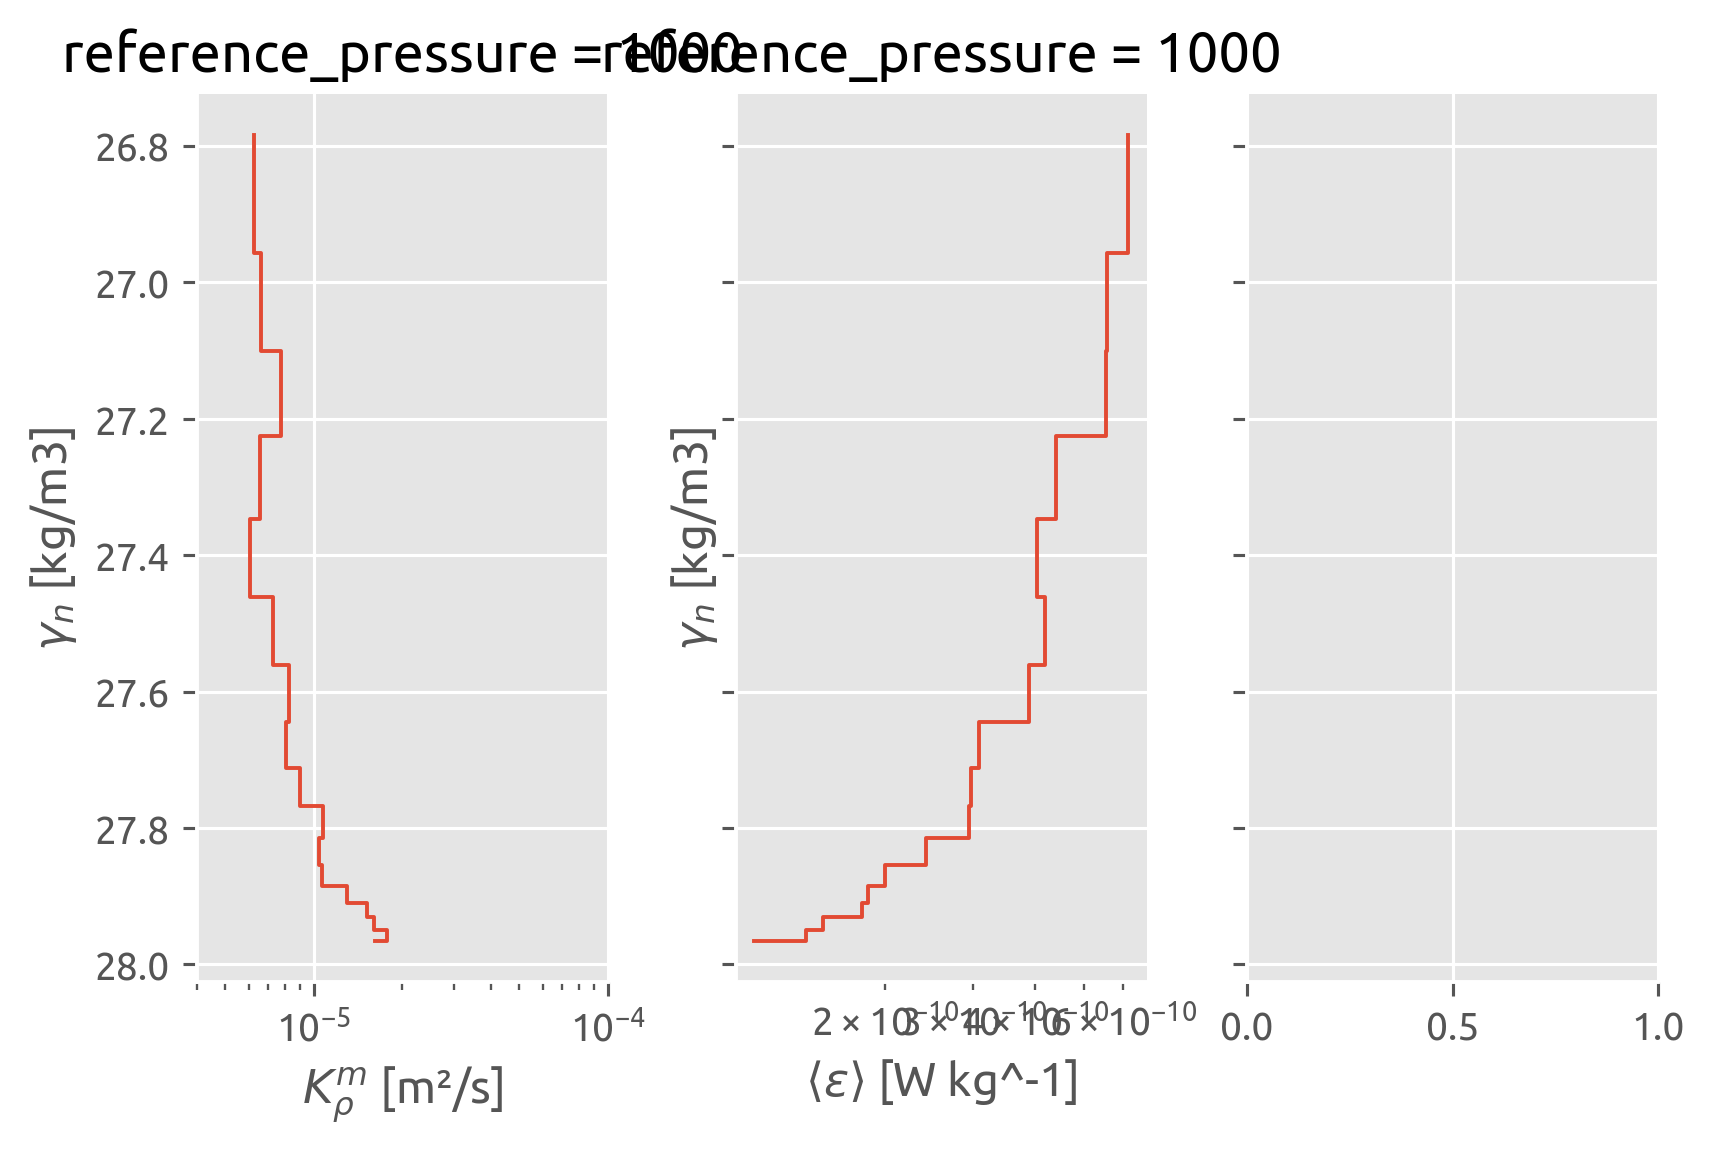

In [23]:
f, ax = plt.subplots(1, 3, sharey=True, constrained_layout=True)
chidens.drop_vars("pres").Krho_m.cf.plot.step(xscale="log", xlim=(4e-6, 1e-4), ax=ax[0])
chidens.drop_vars("pres").eps.cf.plot.step(ax=ax[1], xscale="log")
# chidens["Ke"].cf.plot(ax=ax[2])

## Reproducing production vs dissipation

In [462]:
natre_fine = xr.load_dataset("natre-finestructure.nc")
natre_fine_avg = (
    natre_fine.groupby_bins("pressure", bins=np.arange(250, 2001, 200))
    .mean()
    .cf.guess_coord_axis()
)
natre_fine_avg.pressure_bins.attrs = {
    "positive": "down",
    "standard_name": "sea_water_pressure",
}

In [16]:
colegrad = xr.open_dataset("../datasets/cole-clim-gradient.nc").sel(
    lat=slice(24, 28), lon=slice(360 - 30, 360 - 25)
)
cole = ed.read_cole()
cole_var_all = cole.diffusivity.interp_like(colegrad.dTiso) * colegrad.dTiso ** 2
cole_var_all.attrs = {"long_name": "$K_e^{cole} |∇T_{iso}^{argo}|²$", "units": "°C²/s"}
cole_var = cole_var_all.mean(["lat", "lon"])

groeskamp = xr.open_dataset("/home/deepak/datasets/groeskamp2020/groeskamp2020.nc").sel(
    lat=slice(24, 28), lon=slice(360 - 30, 360 - 25)
)
groeskamp["dTiso"] = colegrad.dTiso.interp(pres=groeskamp.depth)
groeskamp["eddy_var_0"] = groeskamp["Ke_0"] * groeskamp.dTiso ** 2
groeskamp["eddy_var"] = groeskamp["Ke"] * groeskamp.dTiso ** 2
groeskamp = groeskamp.mean(["lat", "lon"])

Ferrari & Polzin use $⟨u_t θ_t⟩.∇θ_m = -Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$, we are instead doing $-⟨K_T θ_z⟩ ∂_zθ_m$. Our estimate mostly agrees with theirs. 


1. Filling in NaNs in the temperature profiles was important. This means more estimates are used in the averages
2. Masked where both $χ$ and $ε$ are both available.
3. Masked so that $|θ_z|$ > 1e-3 (really important, otherwise our estimate is too high)

The comparison with variance production using Cole et al diffusivity and gradients calculated in a similar way disagree significantly between 400 and 1000m. Below that there's not much data but it seems to agree.

The Groeskamp et al (2020) estimate [G2020] is slightly better but not by much. All predict a maximum in variance production near 800m

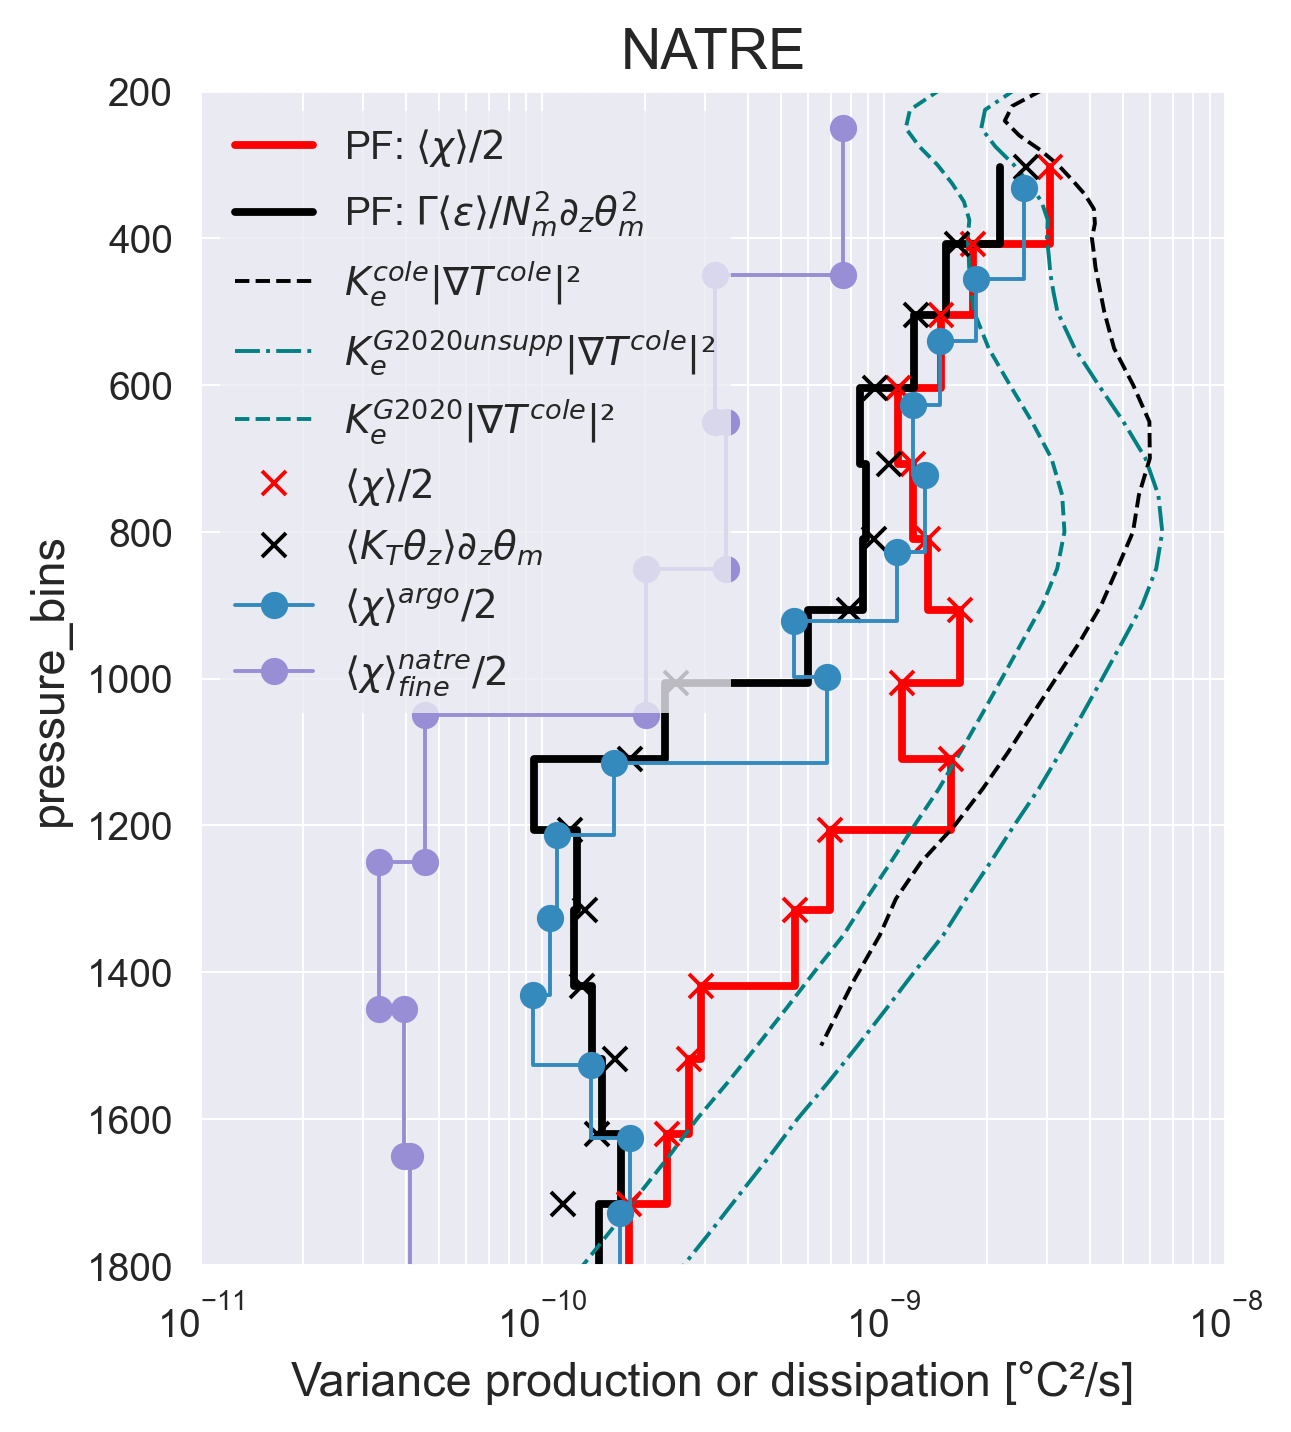

In [449]:
f, ax = plt.subplots(1, 1, constrained_layout=True)

(micro.chi / 2).cf.plot.step(
    y="pres",
    color="r",
    label="PF: $⟨χ⟩/2$",
    lw=2,
    xlim=(1e-11, 1e-8),
    ylim=(1800, 200),
)
(micro.Krho_m * micro.dTdz_m ** 2).cf.plot.step(
    color="k", lw=2, y="pres", label="PF: $Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$"
)

cole_var.plot(y="pres", label="$K_e^{cole} |∇T^{cole}|²$", color="k", ls="--")

groeskamp.eddy_var_0.plot(
    y="depth", label="$K_e^{G2020unsupp} |∇T^{cole}|²$", color="teal", ls="-."
)
groeskamp.eddy_var.plot(
    y="pres", label="$K_e^{G2020} |∇T^{cole}|²$", color="teal", ls="--"
)

ed.sections.plot_var_prod_diss(micro, ls="none", marker="x", ax=plt.gca())

(argo_fine.χ / 2).cf.plot.step(
    marker="o", color="C1", ax=plt.gca(), label="$⟨χ⟩^{argo}/2$"
)

(natre_fine_avg.χ / 2).cf.plot.step(
    marker="o", color="C2", ax=plt.gca(), label="$⟨χ⟩_{fine}^{natre}/2$"
)

# (micro.chi / 2 - micro.Krho * micro.dTdz ** 2).cf.plot.step(
#    y="pres",
#   xscale="log",
#   xlim=(1e-11, 1e-8),
#   ylim=(1800, 200),
#   color="darkblue",
#   lw=1,
#   label="$⟨χ⟩/2 - K_ρ θ^m_z$",
# )

plt.legend()
plt.xlabel("Variance production or dissipation [°C²/s]")
plt.gcf().set_size_inches((4.5, 5))
plt.title("NATRE")
plt.gcf().savefig("../images/natre-estimate.png")

## Studying Cole estimate

We expect to see peak $K_e$ between 600 and 1600m but we mostly don't! Both $⟨S'S'⟩$ and $|∇S|$ are large in the depth we expect a peak. There seems to be approximate agreement in the 1000-1200m range at (-34°E, -32°E) but missing data at deeper depths

Here are estimates of variance produced by eddy stirring at points in the NATRE box from Cole et al (2015). There is some spread but the peak between 400 and 1000 seems robust. Thick black line is the mean over the box.

Text(0.5, 0, '$K_e^{cole} |∇T_{iso}^{argo}|²$ [°C²/s]')

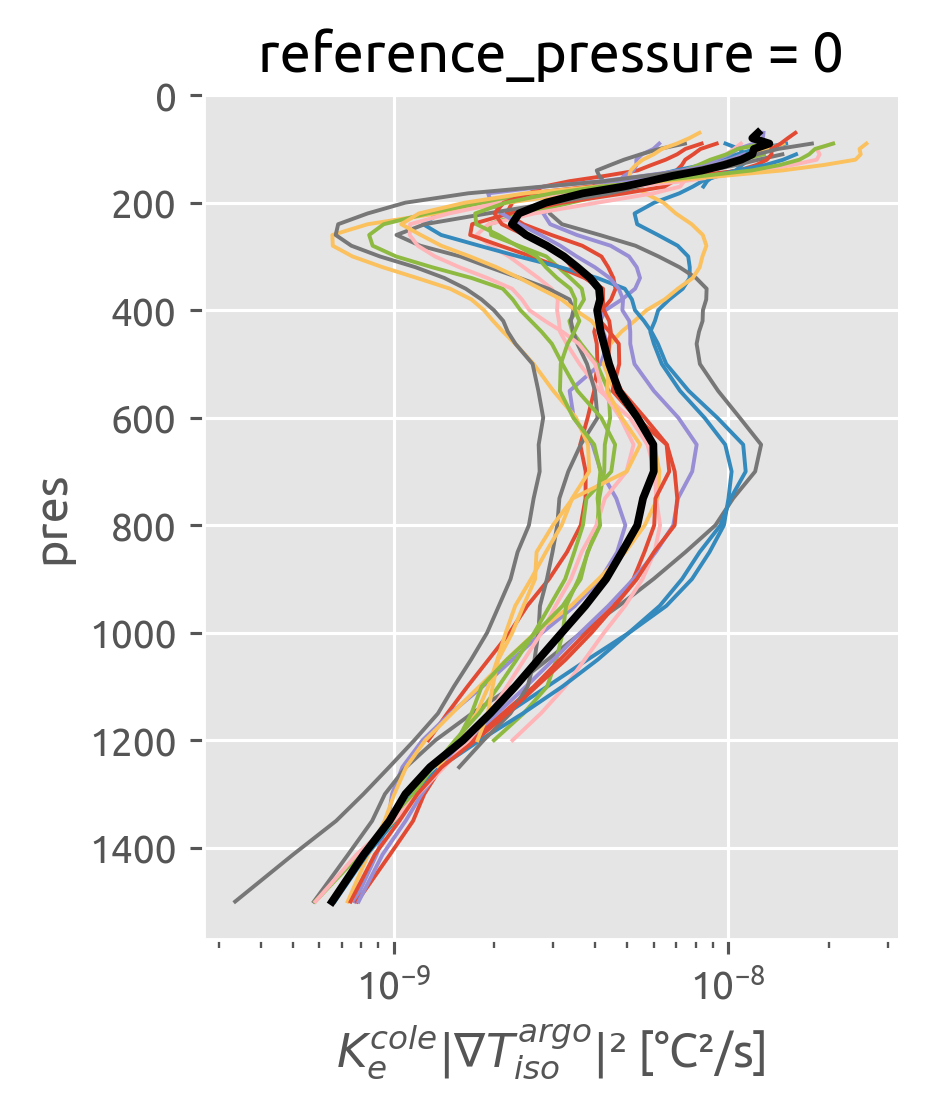

In [32]:
cole_var_all.stack(latlon=["lat", "lon"]).drop("latlon").cf.plot.line(
    y="pres", add_legend=False, size=4, aspect=0.8, xscale="log"
)
cole_var.cf.plot(color="k", lw=2)
plt.xlabel("$K_e^{cole} |∇T_{iso}^{argo}|²$ [°C²/s]")
# (cole.diffusivity.interp_like(dTiso) * colegrad.dSiso**2).mean(["lat", "lon"]).cf.plot()

These are the various terms in the Cole analysis. Note minimum in ∇S between 200 and 800, and associated high mixing lengths ≳ 300km.

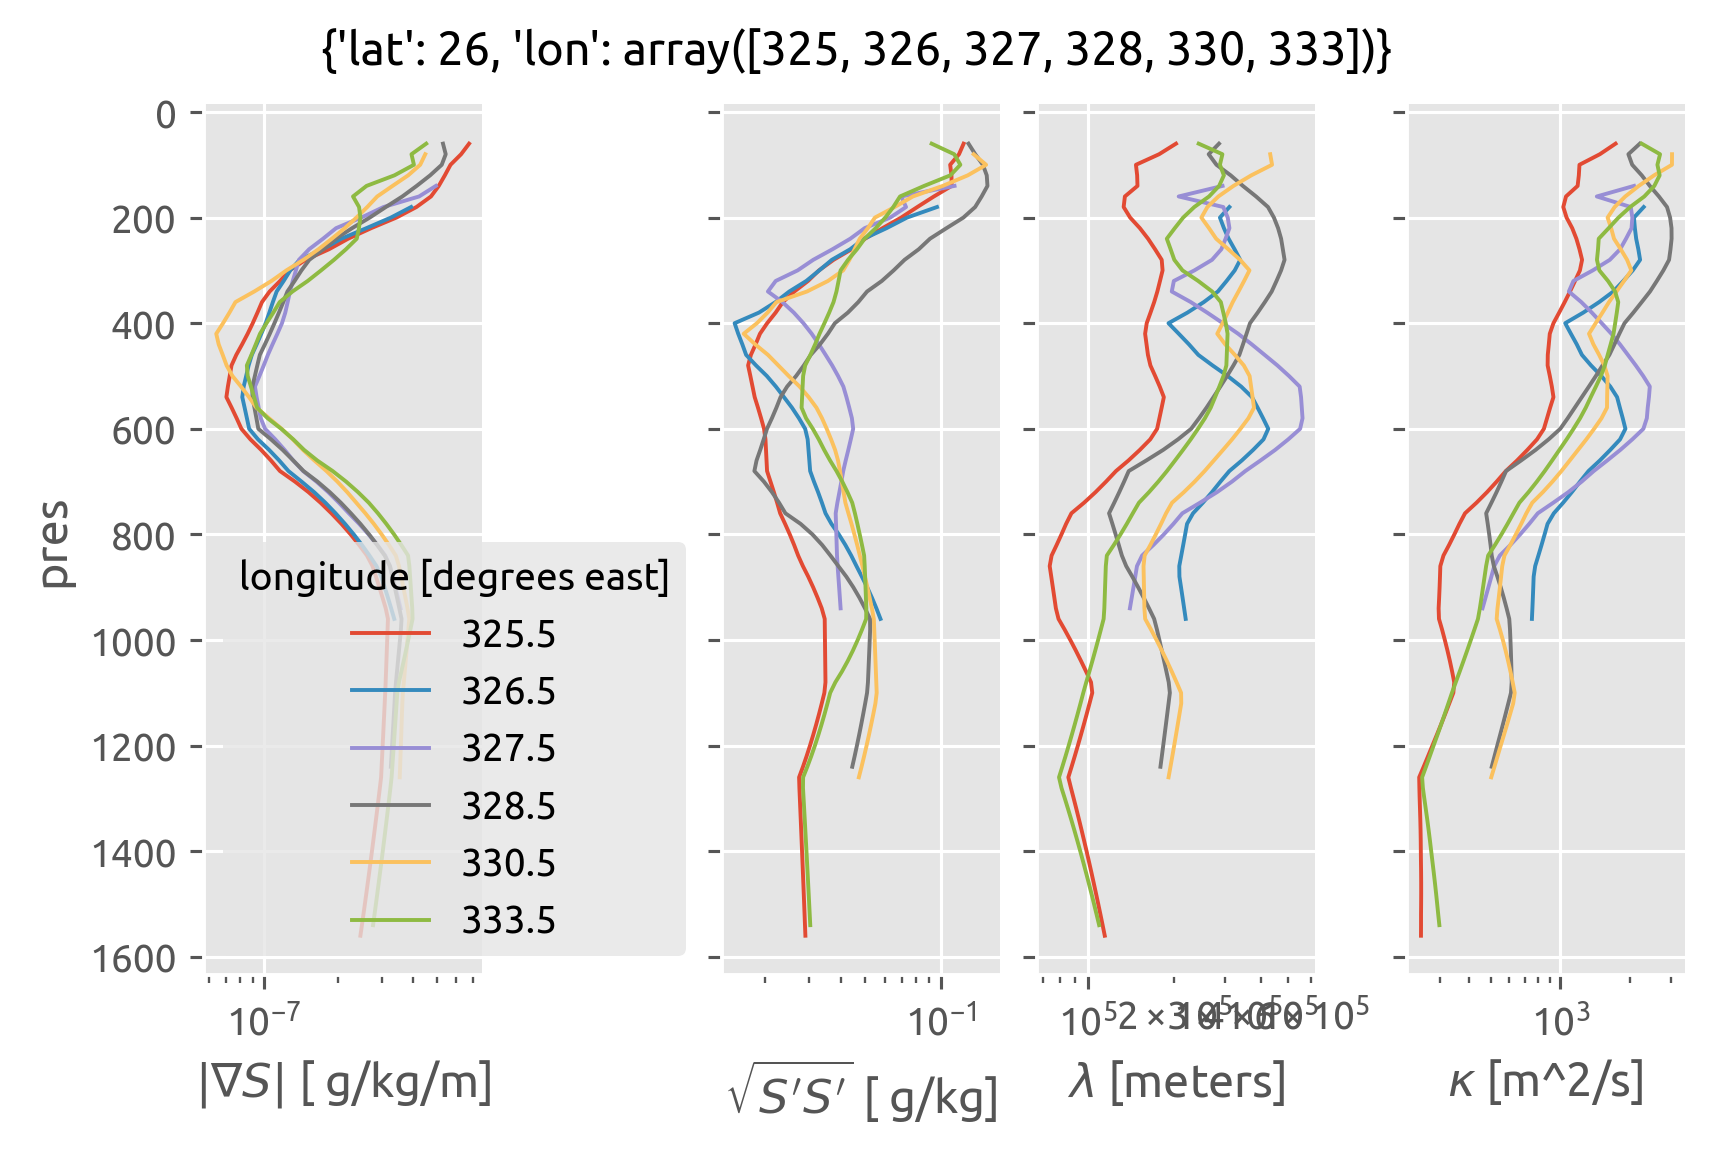

In [68]:
ed.plot.plot_cole_profile(lat=26, lon=360 + np.array([-35, -34, -33, -32, -30, -27]))

## T-S diagrams: Argo vs. NATRE

Lets compare T-S to see if they are similar. I am exploring ways to 

1. interpret the "high" variance production values between 400m and 800m for the Cole estimate. Maybe the NATRE T-S is not representative of the argo T-S?
    - It is representative!
2. explain why the Argo ⟨χ⟩ seems to miss any eddy contribution. Is the scatter less at those density levels?
    - There is some undersampling (of course) because the sampling dz is low below 1000m usually.
    - It seems to capture some of the spread; but the NATRE dataset seems to fill up the space more.
   

The density contours are ρ corresponding to depths `np.arange(200, 2000, 200)` in the Cole dataset. Clearly the top few contours see not much T-S stirring and the T-S relationship is "tight". Ferrari & Polzin interpreted this as a balance between microscale stirring and dissipation. 
- So the high K_e estimate between 400m and 800m in Cole et al (2015) is not supported by the TS spread. 
- Though interestingly the Groeskamp estimate has the same issue then.


Is the finestructure estimate undersampling eddy stirring periods? Compare T-S spread for 
1. all argo profiles
2. argo profiles where I can make a finestructure estimate.
3. NATRE profiles

In [127]:
argo_natre = xr.load_dataset("../datasets/argo/natre.nc")
argo_natre["THETA"] = dcpy.eos.ptmp(
    argo_natre.PSAL, argo_natre.TEMP, argo_natre.PRES, natre.reference_pressure.item()
)
argo_fine_full_profiles = xr.load_dataset("argo_profiles_used_for_finestructure.nc")

In [255]:
# choose density levels that highlight the depth range we are interested in
rho_levels = (
    cole.density_mean_depth.interp_like(colegrad)
    .mean(["lat", "lon"])
    .sel(pres=np.arange(200, 2000, 200), method="nearest")
)

### All argo vs NATRE

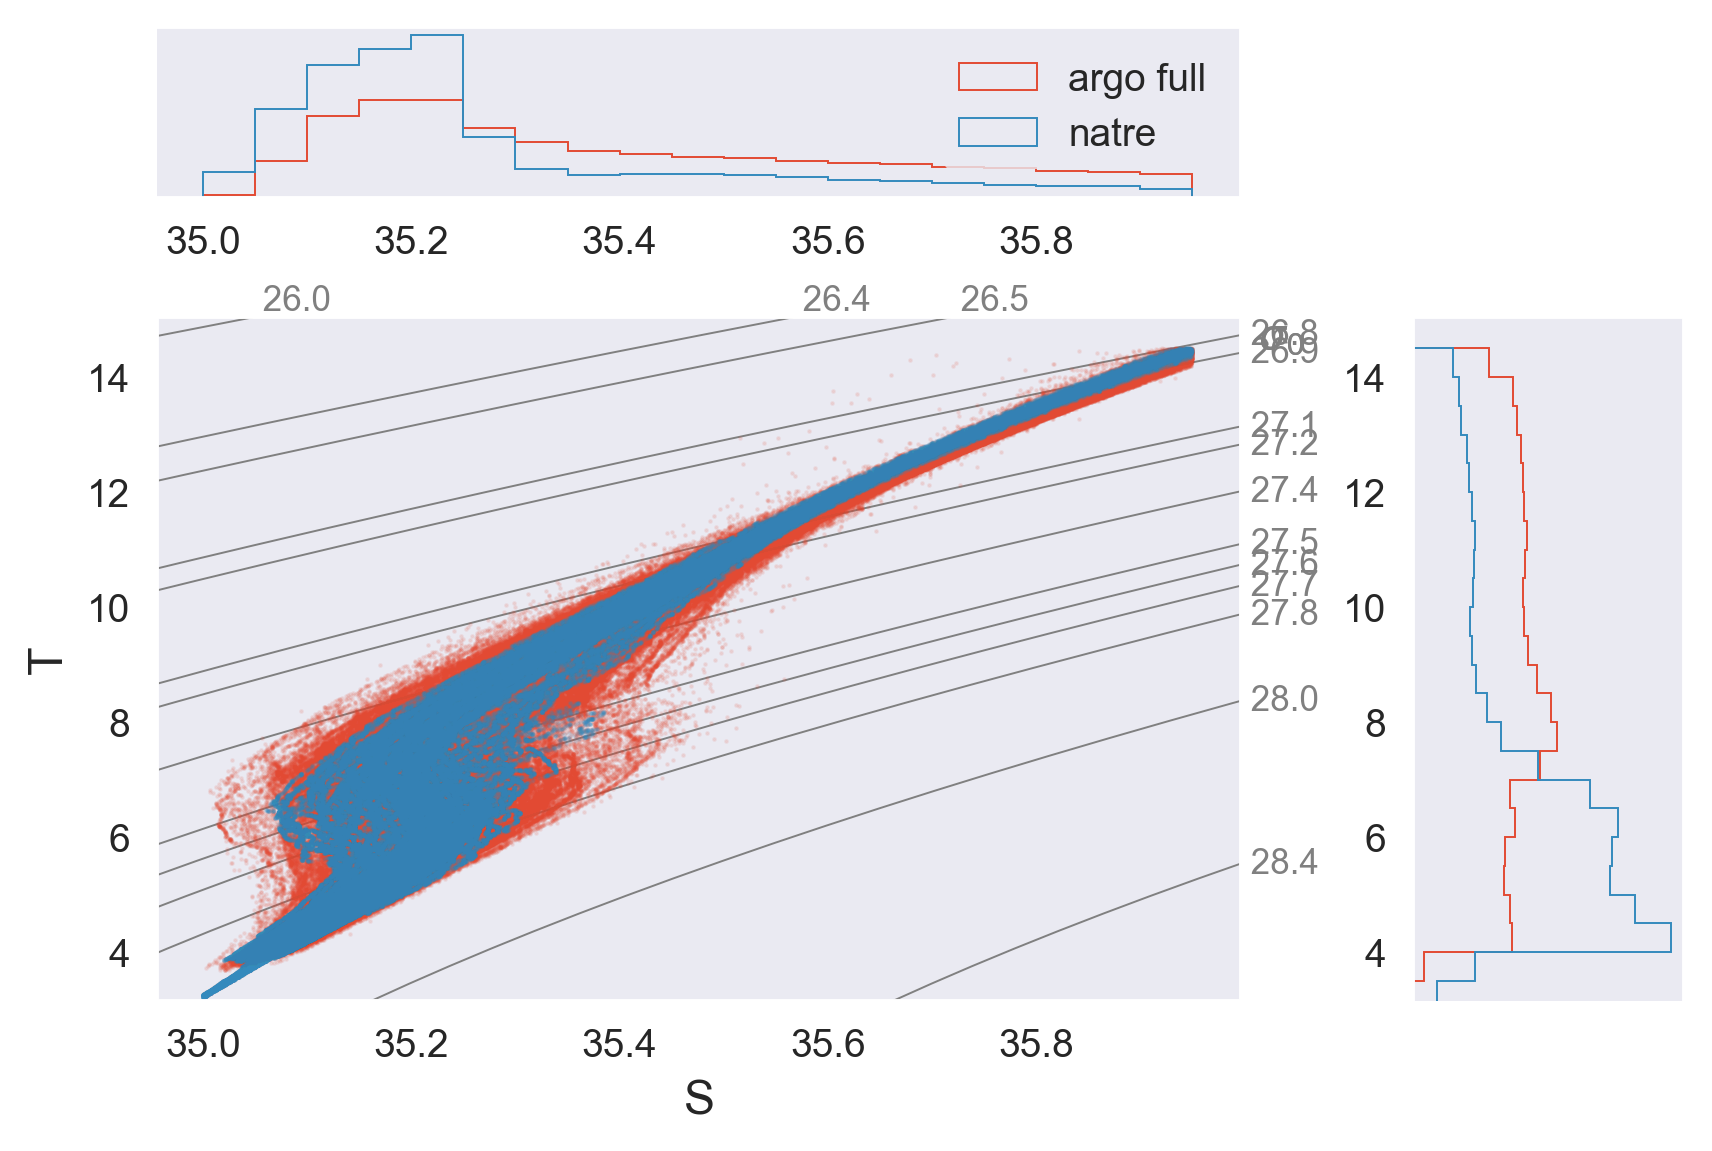

In [260]:
kwargs = dict(
    hexbin=False,
    size=0.5,
    plot_kwargs={"alpha": 0.1},
    Sbins=np.arange(35, 36, 0.05),
    Tbins=np.arange(2, 15, 0.5),
    Pref=0,
)

_, ax = dcpy.oceans.TSplot(
    argo_natre.PSAL,
    argo_natre.THETA,
    **kwargs,
    rho_levels=rho_levels,
)

# mask = argo_fine_full_profiles.fine_deepest_bin > 1000

# _, ax = dcpy.oceans.TSplot(
#    argo_fine_full_profiles.where(mask, drop=True).PSAL,
#    argo_fine_full_profiles.where(mask, drop=True).THETA,
#    **kwargs,
#    rho_levels=rho_levels,
# )

dcpy.oceans.TSplot(
    natre.salt,
    natre.theta,
    ax=ax,
    **kwargs,
)

ax["s"].legend(["argo full", "natre"])
plt.gcf().savefig("../images/ts-natre.png")

### Finestructure Argo vs NATRE

In [261]:
kwargs = dict(
    hexbin=False,
    size=0.5,
    plot_kwargs={"alpha": 0.1},
    Sbins=np.arange(35, 36, 0.05),
    Tbins=np.arange(2, 10, 0.5),
    Pref=0,
)

The distributions look similar and the argo data capture more extremes; but the NATRE data fill a lot of the space (though smaller S.D.). Maybe the average isn't that great and it's totally undersampling

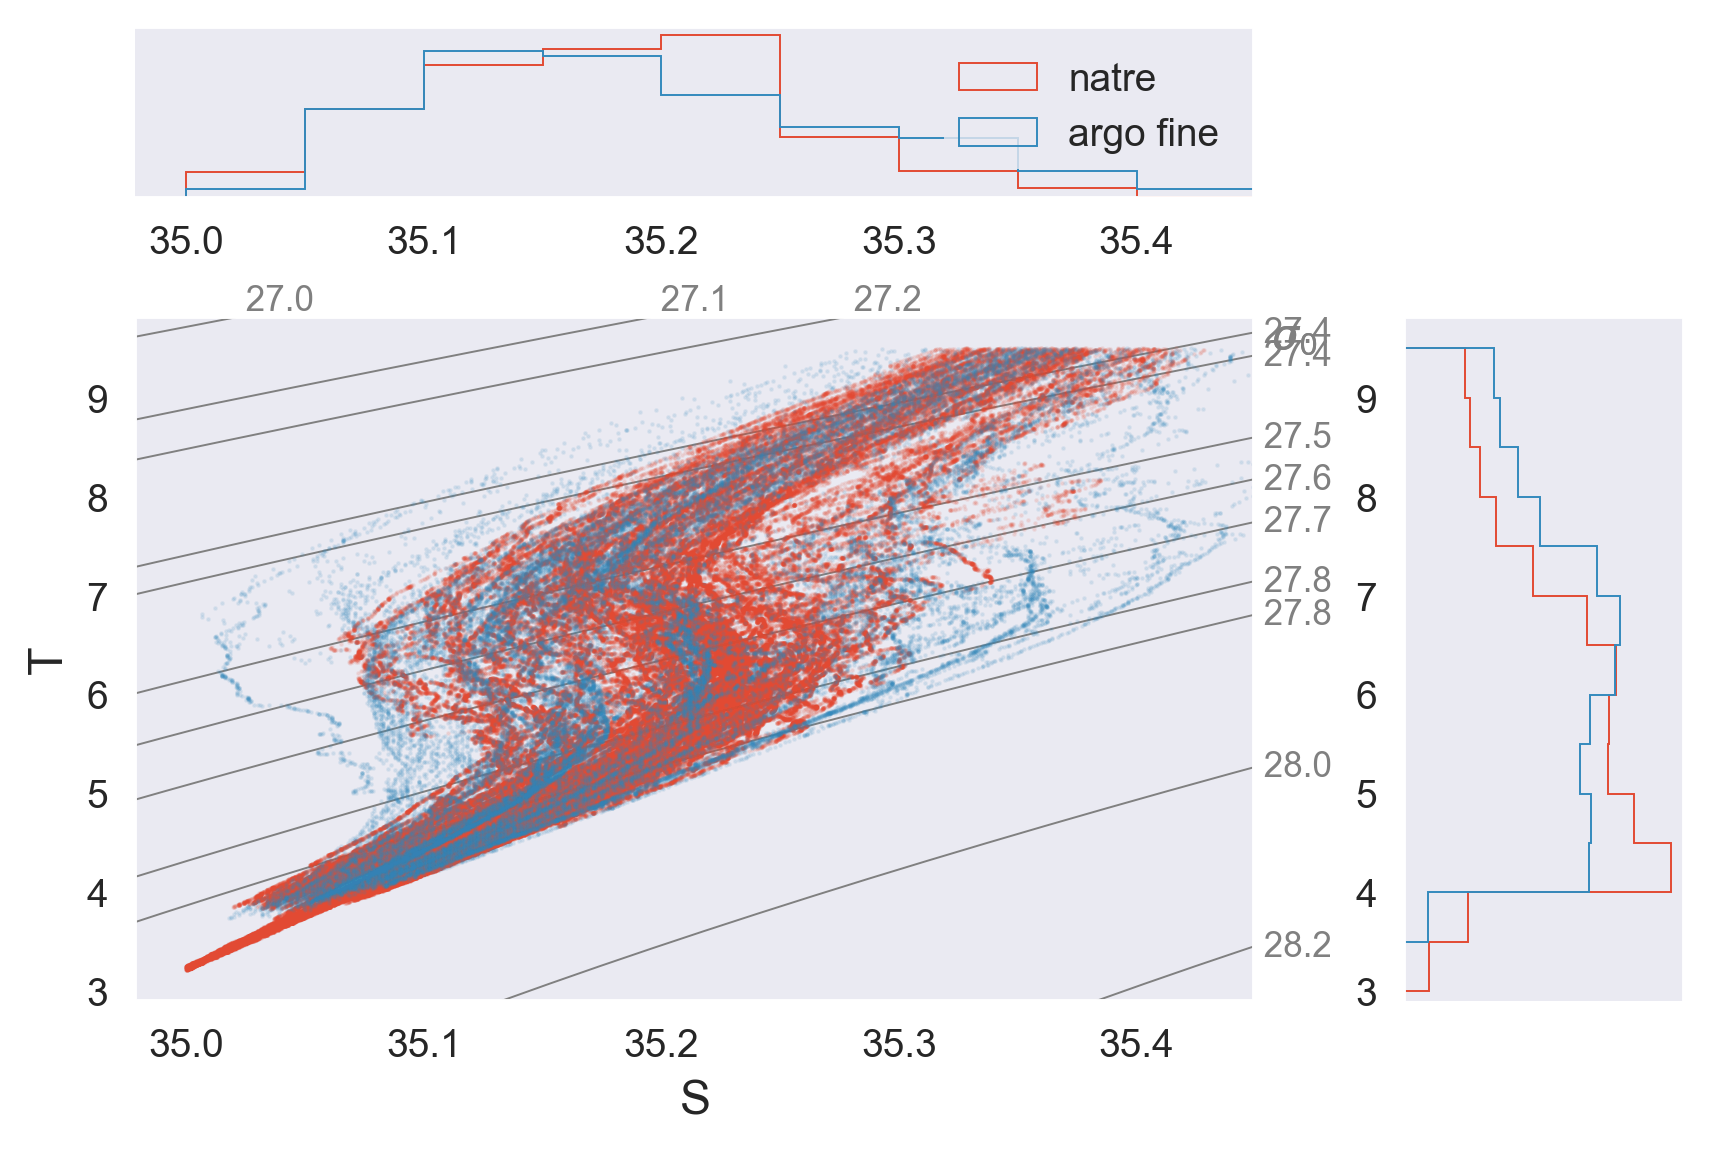

In [266]:
mask = argo_fine_full_profiles.fine_deepest_bin > 1000

_, ax = dcpy.oceans.TSplot(
    natre.salt,
    natre.theta,
    **kwargs,
    rho_levels=rho_levels,
)

dcpy.oceans.TSplot(
    argo_fine_full_profiles.where(mask, drop=True).PSAL,
    argo_fine_full_profiles.where(mask, drop=True).THETA,
    ax=ax,
    **kwargs,
)

ax["s"].legend(["natre", "argo fine"])
plt.gcf().savefig("../images/ts-natre.png")

It's definitely a big undersampling when compared to all Argo profiles in the area. **How good is good enough?** 

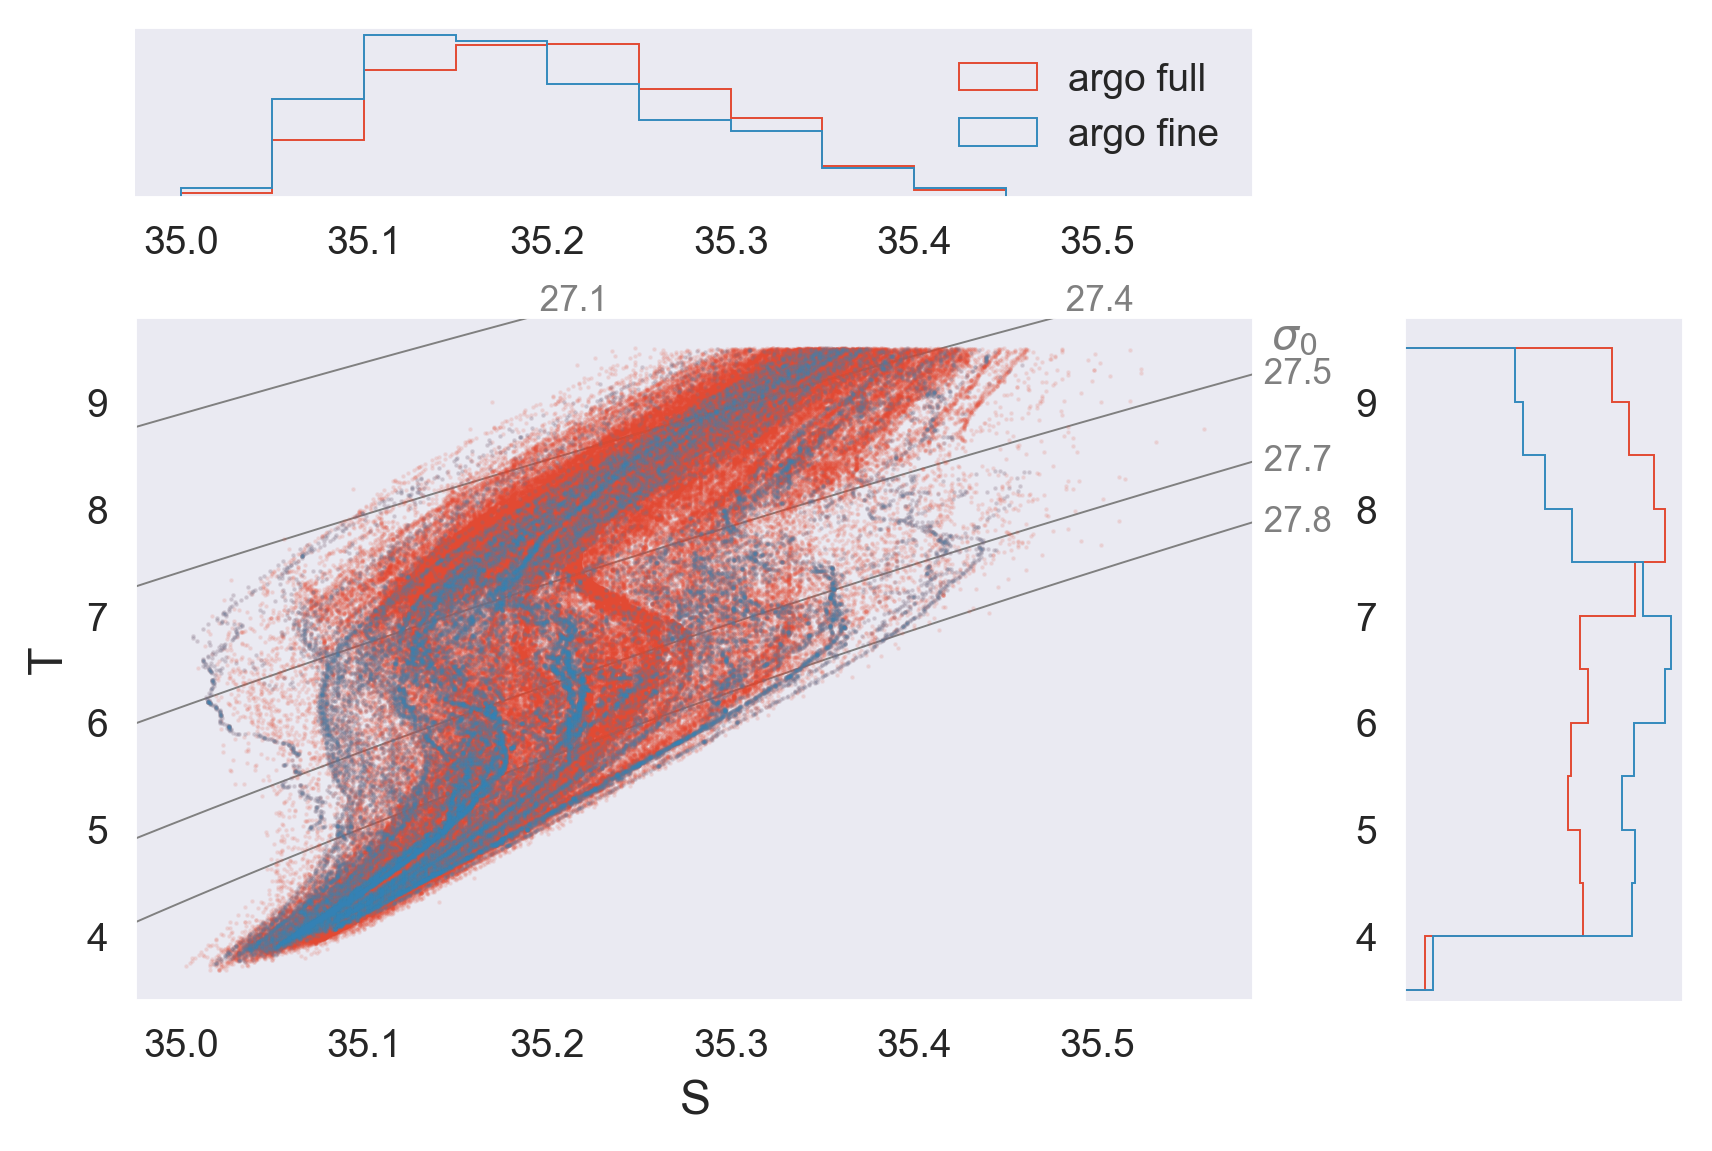

In [267]:
_, ax = dcpy.oceans.TSplot(
    argo_natre.PSAL,
    argo_natre.THETA,
    **kwargs,
    rho_levels=rho_levels,
)

mask = argo_fine_full_profiles.fine_deepest_bin > 1000


masked = argo_fine_full_profiles.where(mask, drop=True)
_, ax = dcpy.oceans.TSplot(
    masked.PSAL,
    masked.THETA,
    ax=ax,
    rho_levels=None,
    **kwargs,
)


masked.groupby
ax["s"].legend(["argo full", "argo fine"])
plt.gcf().savefig("../images/ts-natre-argo.png")

### Conclusions

1. Can we define a metric using (T-S spread in all argo profiles) vs (TS spread in profiles where we can make a finestructure estimate) to decide where we might be able to make an estimate using Argo?
2. Can we refine this?
    - If we expect regions above 1000m then it might not be so bad.
    - Could make a bigger box? (skeptical)
    
3. This really points out the limitation of the finestructure estimate, at least deeper down?
    - How does the Whalen scatter plot work out?

### Is there spatial uncertainty? Cole estimate: Are we looking in the wrong place? No

Here's the NATRE region marked on a map of $K_e$. There is just low diffusivity everywhere in the box; but may be the mean signal is just northwest of the box

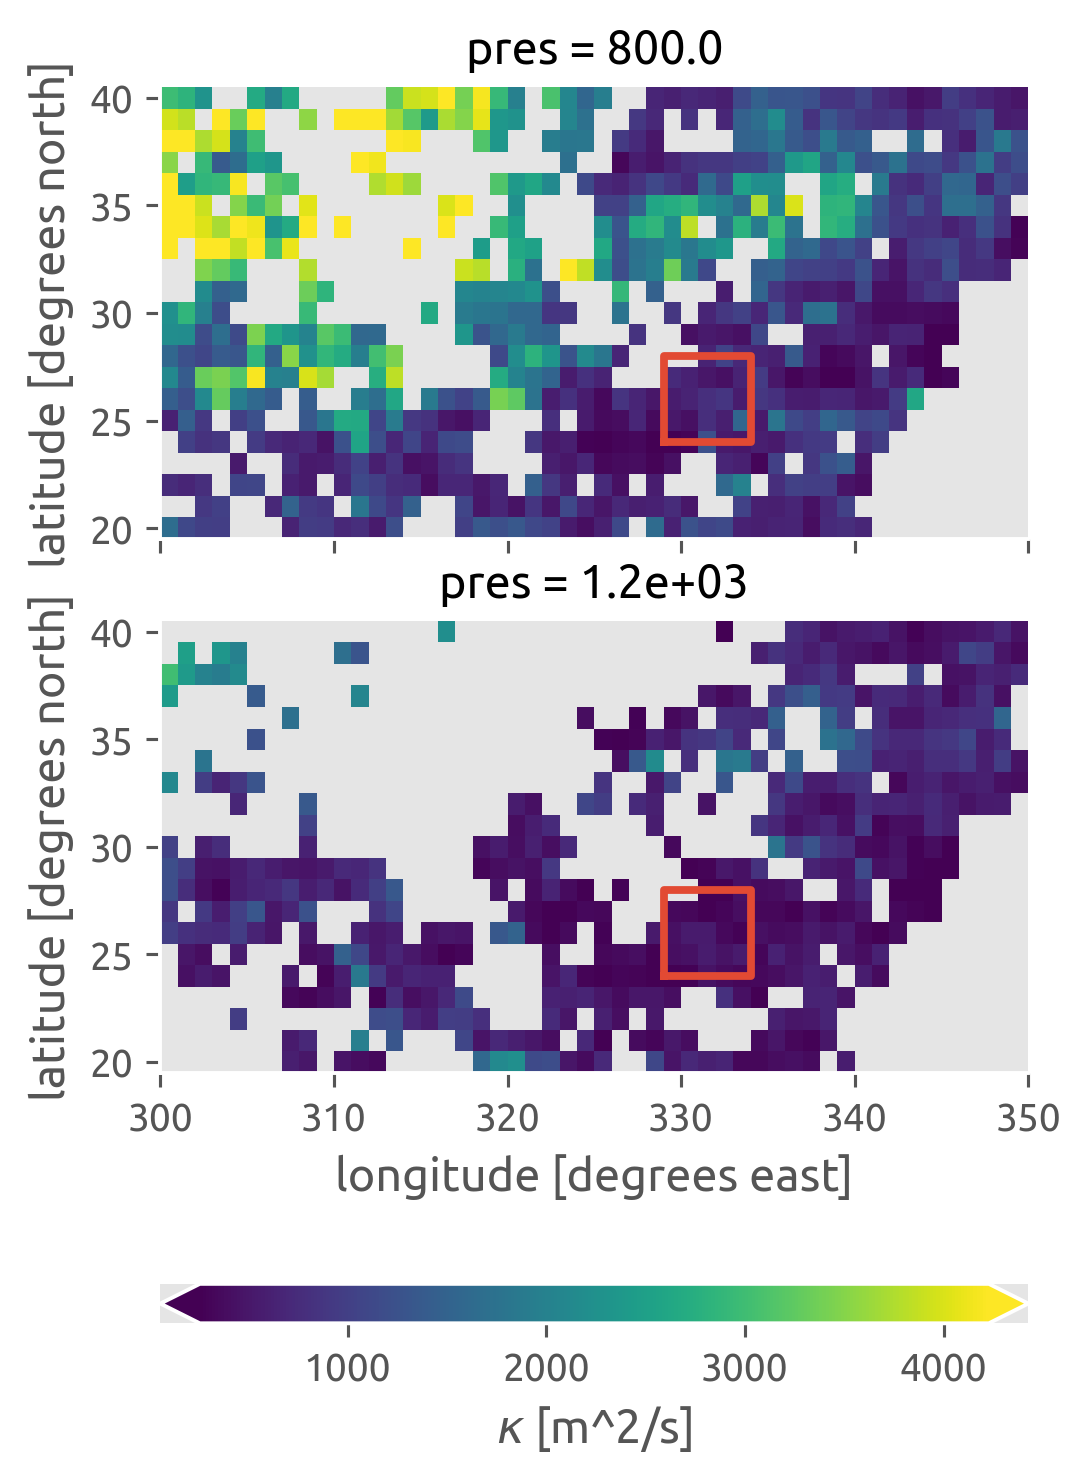

In [56]:
fg = (
    cole.diffusivity.sel(pres=[800, 1200], method="nearest")
    .sel(lon=slice(300, 350), lat=slice(20, 40))
    .plot(robust=True, row="pres", cbar_kwargs={"orientation": "horizontal"})
)

fg.map(
    lambda: plt.plot(
        360 + np.array([-31, -26, -26, -31, -31]), [24, 24, 28, 28, 24], lw=2
    )
)

## Sensitivity of χpod estimate to mean K estimate

Various estimates of the variance produced by turbulent stirring of mean vertical gradient

1. Ferrai & Polzin (2005): $Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$ 
2. χpod estimate: $⟨K_T θ_z⟩ ∂_zθ_m$
3. (1) with $ε_χ$ : $Γ ⟨ε_χ⟩/N_m^2  ∂_zθ_m^2$
4. (2) with $K_ρ$ instead of $K_T$: $⟨K_ρ θ_z⟩  ∂_zθ_m^2$; $K_ρ ≪ K_T$, so this is not good

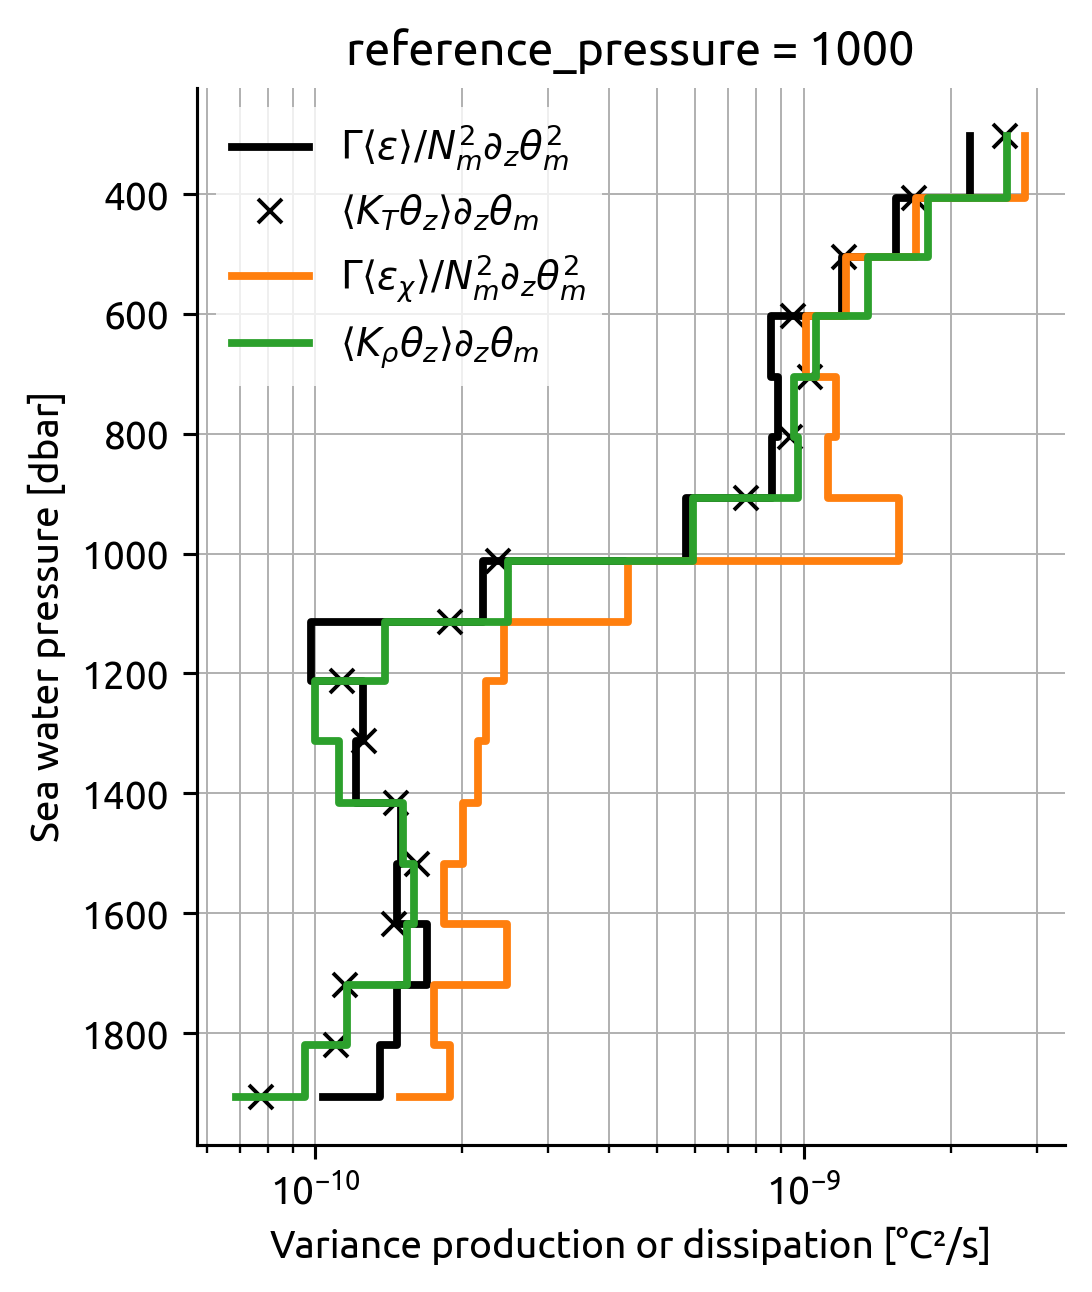

In [39]:
(chidens.Krho_m * chidens.dTdz_m ** 2).cf.plot.step(
    color="k", lw=2, label="$Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$"
)

(chidens.KtTz * chidens.dTdz_m).cf.plot.step(
    color="k", marker="x", ls="none", label="$⟨K_T θ_z⟩ ∂_zθ_m$"
)

(0.2 * chidens.eps_chi / chidens.N2_m * chidens.dTdz_m ** 2).cf.plot.step(
    color="C1", lw=2, label="$Γ ⟨ε_χ⟩/N_m^2  ∂_zθ_m^2$"
)

(chidens.KrhoTz * chidens.dTdz_m).cf.plot.step(
    lw=2, label="$⟨K_ρ θ_z⟩  ∂_zθ_m$", color="C2"
)

plt.grid(True, which="both", lw=0.5)

plt.legend()
plt.xscale("log")
plt.xlabel("Variance production or dissipation [°C²/s]")
plt.gcf().set_size_inches((4, 5))

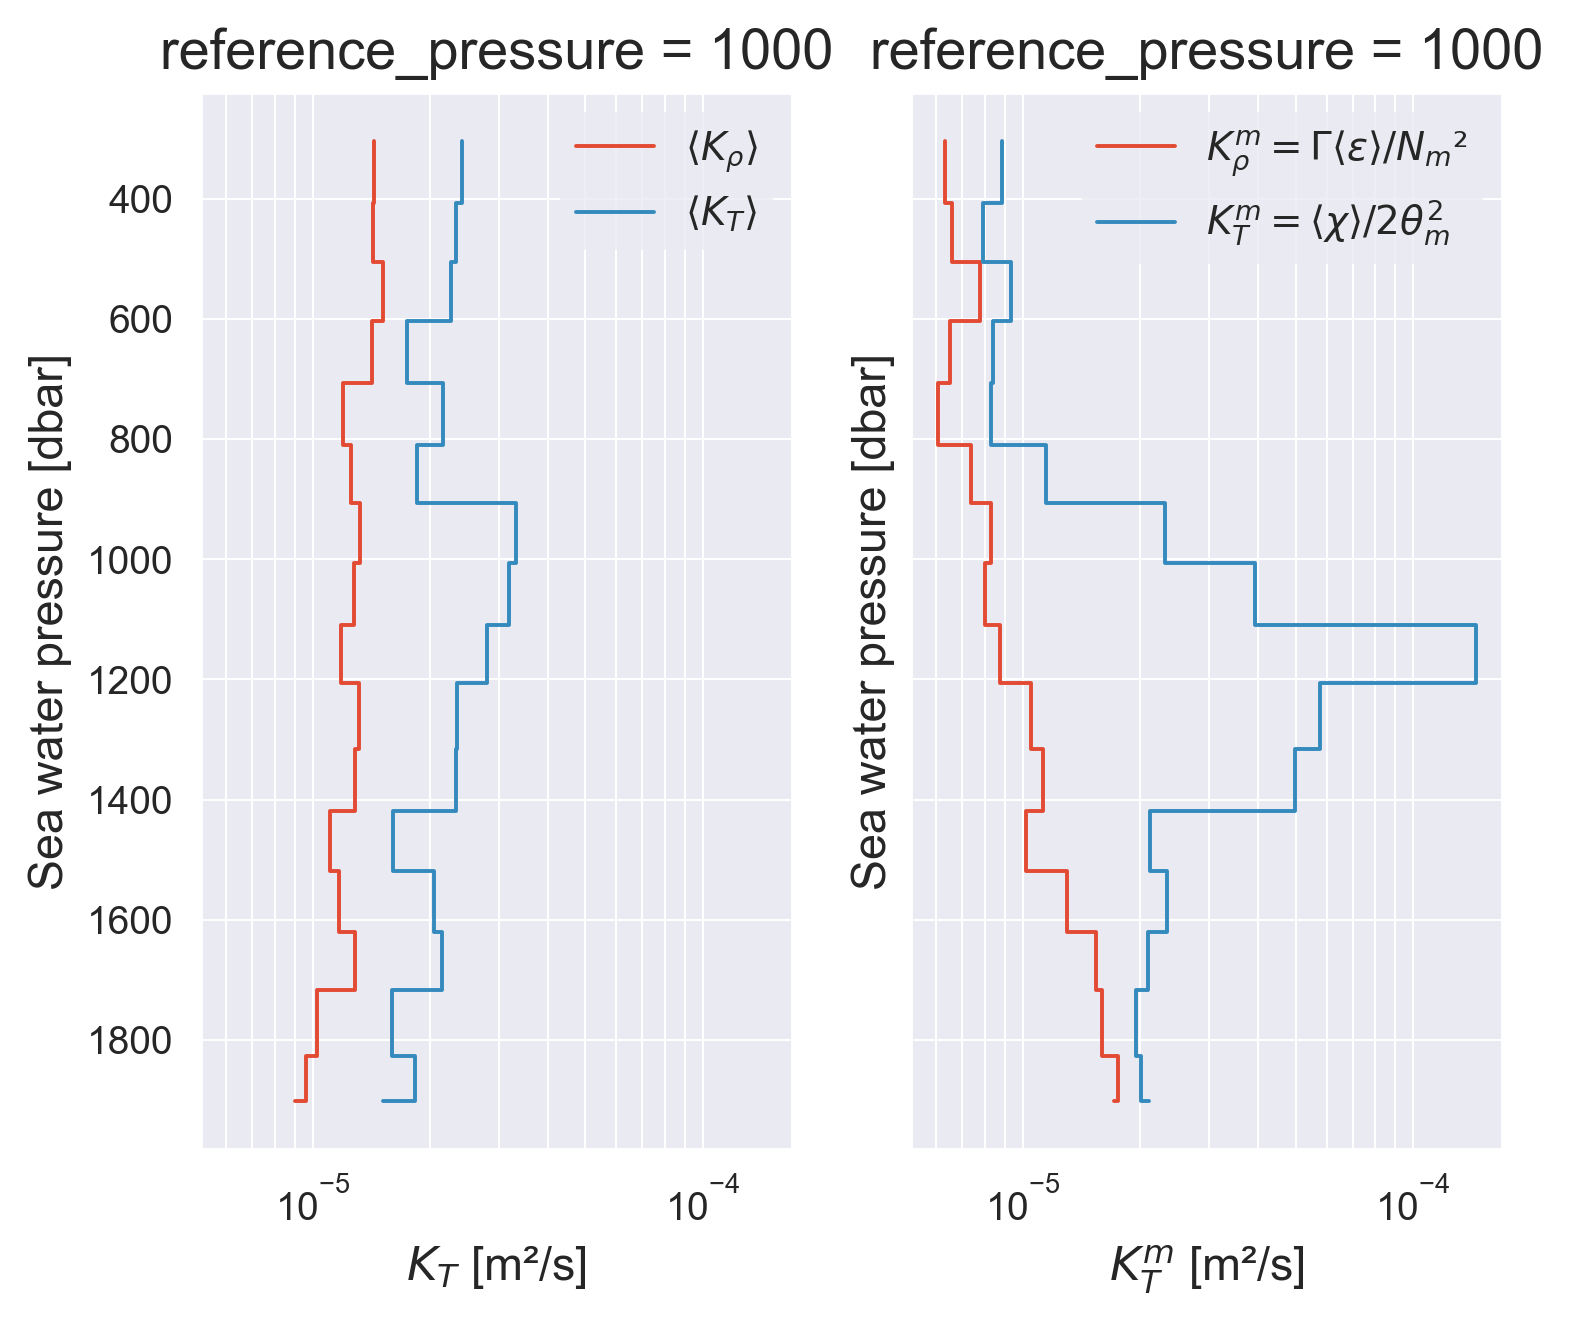

In [674]:
f, ax = plt.subplots(1, 2, sharey=True, sharex=True)
micro.Krho.cf.plot.step(y="pres", xscale="log", ax=ax[0])
micro.Kt.cf.plot.step(y="pres", ax=ax[0])
micro.Krho_m.cf.plot.step(y="pres", ax=ax[1])
micro.Kt_m.cf.plot.step(y="pres", ax=ax[1])
ax[0].legend(["$⟨K_ρ⟩$", "$⟨K_T⟩$"])
ax[1].legend(["$K_ρ^m = Γ ⟨ε⟩/N_m²$", "$K_T^m = ⟨χ⟩/2θ_m^2$"])
[aa.grid(True, which="both", lw=0.5) for aa in ax]
plt.gcf().set_size_inches((6, 5))

## Todo:

1. [ ] refactor finestructure + NATRE stuff to its own notebook.


See sensitivity to using
1. [x] $⟨K_ρ θ_z⟩ θ_z^m = ⟨Γε/N² θ_z⟩ θ_z^m$
2. [x] Use $Γ ⟨ε_χ⟩/N_m^2$
3. [x] Using neutral density bins instead of $σ_{1}$
4. [x] $T_z$ filtering